In [12]:
from numpy import sin, cos, linalg, array, pi, arange
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import itertools
import warnings

In [73]:
class Pendulum:

    def __init__(self, Δx, θ_0, ω_0, r):
        self.ℓ = 0.1
        self.g = 9.8
        self.θ = [θ_0]
        self.ω = [ω_0]
        self.r = r
        self.Δx = Δx
        
        self.ρ = 1 ### density
        self.m = 4/3*pi*self.r**3*self.ρ ### mass = volume*density

    # Returns the gradient of theta (omega)
    def θGrad(self, θ, ω):
        return ω

    # Returns the gradient of omega (omega')
    def ωGrad(self, θ, ω):
        return -1*self.g/self.ℓ*sin(θ)
        
    # Update theta and omega for timestep delta, according to the Euler method.

    def IntegrateStep(self, delta):
        """
        Append new theta and omega states to the internal lists, which result from
        the time step delta. Integration done via the Runge–Kutta Method.
        """
        j, k = {}, {}
      
        j[0] = k[0] = 0

        for i in [1, 2, 3, 4]:
            h = delta/2 if i == 2 or i == 3 else delta

            for (var, func) in [(j, self.θGrad),(k, self.ωGrad)]:
                
                var[i] = func(self.θ[-1] + h*var[i-1], self.ω[-1] + h*var[i-1])
        
        for (var, state) in [(j, self.θ), (k, self.ω)]:
            
            state.append(state[-1] + h/6*(var[1] + 2*var[2] + 2*var[3] + var[4]))
    
        return
    
    
    def Transform(self, θ):
        return (self.ℓ*sin(θ)+self.Δx, -self.ℓ*cos(θ))
    
    def MakeArtists(self):
        (x, y) = self.Transform(self.θ[-1])
        
        mass = plt.Circle((x, y), radius=self.r , color='k')
        
        string, = plt.plot([self.Δx, x], [0, y], '-', color='k')
        
        return [mass, string]
    
class Cradle:
    
    def __init__(self, pendParams):
        self.pendulums = self.InitialisePends(pendParams)

        
    def InitialisePends(self, pendParams):
        pendulums = []
        
        ## ϵ is the spacing between masses at rest
        ϵ = 0.0001
        width = 0
        for (θ_0, ω_0, r) in pendParams:
            width += r + ϵ
            
        ## symmetrically place pendulums around x = 0
        Δx = -width/2
        
        assert(len(pendParams)>0)
        (θ_0, ω_0, r) = pendParams[0]
        pendulums.append(Pendulum(Δx, θ_0, ω_0, r))
        Δx += r
        for i in range(1, len(pendParams)):
            (θ_0, ω_0, r) = pendParams[i]
            Δx += r + ϵ
            pendulums.append(Pendulum(Δx, θ_0, ω_0, r))
            
        return pendulums
    
    def HasCollided(self, pen1, pen2):
        pen1_loc = array(pen1.Transform(pen1.θ[-1]))
        pen2_loc = array(pen2.Transform(pen2.θ[-1]))
        if linalg.norm(pen1_loc - pen2_loc) <= pen1.r + pen2.r:
            if linalg.norm(pen1_loc - pen2_loc) <= 0.95*(pen1.r+pen2.r):
                raise ValueError("Collision detected late, consider using a smaller time step!")
            return True
    
    def ElectrostaticRepulsion(self):
        for (pen1, pen2) in itertools.combinations(self.pendulums, 2):
            if self.HasCollided(pen1, pen2):
                temp_ω = pen1.ω[-1]
                pen1.ω[-1] = (pen1.m-pen2.m)/(pen1.m+pen2.m)*temp_ω + (2*pen2.m/(pen1.m+pen2.m))*pen2.ω[-1]
                pen2.ω[-1] = (2*pen1.m/(pen1.m+pen2.m))*temp_ω + (pen2.m-pen1.m)/(pen1.m+pen2.m)*pen2.ω[-1]
    

In [81]:
from matplotlib import rcParams, rc
from IPython.display import HTML
##Warning this code requires a working latex installation to execute and ffmpeg

rcParams['figure.dpi'] = 300
rcParams['figure.figsize'] = (16/2,9/2)


def render_draft():
    rcParams['figure.dpi'] = 80
    rcParams['figure.figsize'] = (8,6)

def render_final():
    rcParams['figure.dpi'] = 300
    rcParams['figure.figsize'] = (8,6)

In [83]:
from matplotlib import animation

def plot_physics(timeinterval, pendParams):
    t_step = 0.000001
    t_domain = arange(0, timeinterval, t_step)
    last_frame = 0
    frame_length = 1/60
    
    cradle = Cradle(pendParams)
    
    fig = plt.figure()
    plt.axis('off')
    ax = plt.gca()
    ax.set_aspect(aspect=1)

    plt.ylim((-0.12, 0.02))
    plt.xlim((-.07, 0.07))

    ## initialise environment
    
    object_instances = []
    
    last_collision = 0
    
    for t in t_domain:
        if t - last_collision > t_step:
            cradle.ElectrostaticRepulsion()
            last_collision = t
        
        for pend in cradle.pendulums:
            pend.IntegrateStep(t_step)
        
        if t - last_frame >= frame_length:
            objects = []
            for pend in cradle.pendulums:
                (mass, string) = pend.MakeArtists()
                objects.append(string)
                objects.append(ax.add_patch(mass))
            object_instances.append(objects)
            last_frame = t
    
    ani = animation.ArtistAnimation(fig, object_instances, interval=frame_length*1000*2)

    return HTML(ani.to_html5_video())

Today I achieved the milestones in the plan;

 - Use the single pendulum class as a starting point, use it to replicate the lab results in ```matplotlib```
 - Create a ``matplotlib`` objects to draw the system 
 - (2)
 - Add two pendulums swinging simultaneously on the same plot

With too larger timestep used in the integration method, the system diverges from real behavior and it gains energy. With my initial method I was plotting the objects each time the ```IntegrateStep``` method was called - this resulted in long computation times. For smooth motion to appear to a human, we only need to plot 60 frames per second or so. So I have decided to call ```MakeArtists``` only once every 1/60 simulated seconds to achieve this - this significantly reduces computation time.

Im having the problem that sometimes the spheres get stuck inside one another. I've added an exception to be raised if the collision is detected within the first 5% of the sphere's radii - this causes the code to abort immediately.


I noticed that the internal pendulums begin to move after some time. This occurs during a real newton's cradle too. It happens if any of the pendlumus collide with an angle non-paralell to the vertical ($\theta != 0$ ). If this ever occurs, the pendulums will begin to be accelerated by gravity - when the pendulum collides again this will result in a runaway postitive feedback loop.

I have improved the code so that the masses are plotted using the ```Circle``` patch rather than a marker - this allows a precise radius to be given (admittedly, I was previously doing this via trail and error.) With this issue fixed, we can develop the code for different radii. Recalling the mathematical framework set out in the plan for this project we are going to say that all pendulum masses are made of the same metal (the same density), so their mass is proportional to their volume. To make this functional we need to

- Compute the pendulum's mass based on the radius given
- Update the elastic collision formula for non-equal mass colisions

Done by adding;
```python
        self.ρ = 1 ### density
        self.m = 4/3*np.pi*self.r**3*self.ρ ### mass = volume*density
```

and implement 

$$\dot{\theta}_{i,f} = \frac{m_i-m_j}{m_i+m_j} \dot{\theta}_{i,i} + \frac{2m_j}{m_i+m_j} \dot{\theta}_{j, i}$$  
$$\dot{\theta}_{j,f} = \frac{2m_i}{m_i+m_j} \dot{\theta}_{i,i} + \frac{m_j-m_i}{m_i+m_j} \dot{\theta}_{j, i}$$

with 

```python
    if self.HasCollided(pen1, pen2):
        temp_ω = pen1.ω[-1]
        pen1.ω[-1] = (pen1.m-pen2.m)/(pen1.m+pen2.m)*temp_ω + (2*pen2.m/(pen1.m+pen2.m))*pen2.ω[-1]
        pen2.ω[-1] = (2*pen1.m/(pen1.m+pen2.m))*temp_ω + (pen2.m-pen1.m)/(pen1.m+pen2.m)*pen2.ω[-1]
```

I have made the radius now a required argument to be placed in the ```pendParams``` tuple list

<ipython-input-23-daa6a0c2f173>:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)


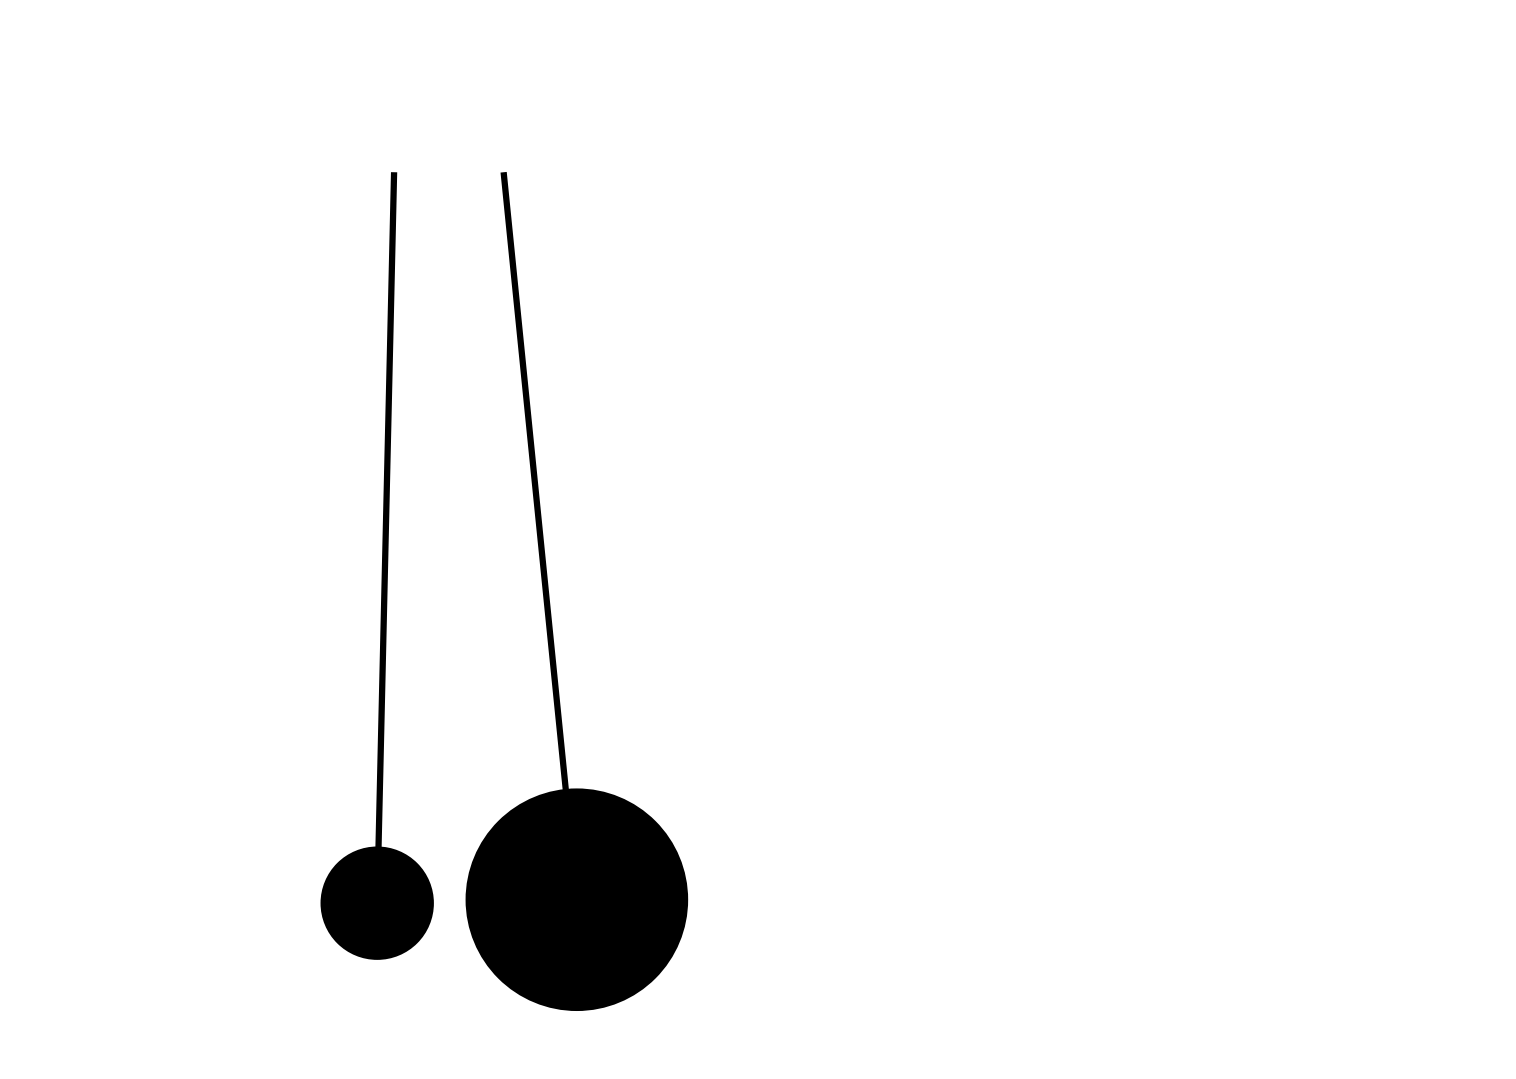

In [24]:
pendParams = [(0, 0, 0, 0.0075),
              (0.0151, 0.2, 0, 0.01500)]

plot_physics(5, pendParams)

Looks cool!

We are still manually specifying the distance between pendulums, I don't think this should be something that we care about, rather the distance should be given by the neighboring radii plus some small $\epsilon>0.$
```python
        for (Δx, θ_0, ω_0, r) in pendParams:
            pendulums.append(Pendulum(Δx, θ_0, ω_0, r))
 ```
 with
 ```python
        assert(len(penParams)>0)
        (θ_0, ω_0, r) = pendParams[0]
        pendulums.append(Pendulum(0, θ_0, ω_0, r))
        Δx = r
        for i in range(1, len(pendParams)):
            (θ_0, ω_0, r) = pendParams[i]
            Δx += r + 0.0001
            pendulums.append(Pendulum(Δx, θ_0, ω_0, r))
```

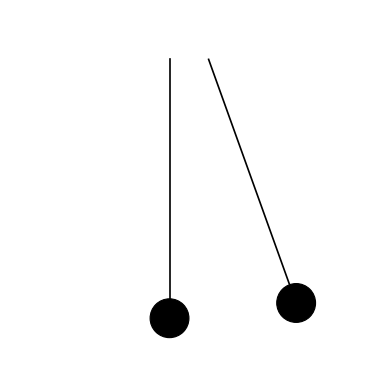

In [84]:
render_draft()
pendParams = [(0, 0, 0.0075),
              (0.5, 0, 0.0075)]

plot_physics(.1, pendParams)

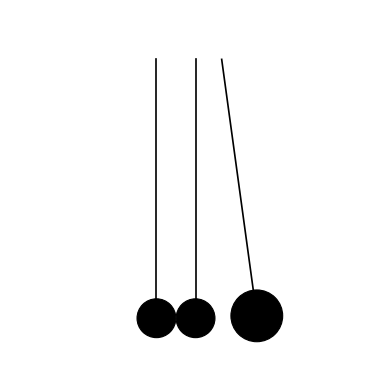

In [85]:
pendParams = [(0, 0, 0.0075),
              (0, 0, 0.0075),
              (.2, 0, 0.0100)]

plot_physics(.1, pendParams)